## Splink data linking and deduplication demo 

In this demo we link and simultaneously dedupe two datasets which themselves contain duplicates.


## Step 1:  Imports and setup

The following is just boilerplate code that sets up the Spark session and sets some other non-essential configuration options

In [1]:
import pandas as pd 
pd.options.display.max_columns = 500
pd.options.display.max_rows = 100
import altair as alt
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [2]:
import logging 
logging.basicConfig()  # Means logs will print in Jupyter Lab

# Set to DEBUG if you want splink to log the SQL statements it's executing under the hood
logging.getLogger("splink").setLevel(logging.INFO)

In [3]:
from utility_functions.demo_utils import get_spark
spark = get_spark()

## Step 2:  Read in data

In this example, we read in two datasets, `df_1` and `df_2`.  These will be provided to `Splink` as a list like `[df_1, df_2]`.  By adding additional elements to this link, you can use `Splink` to link and deduplicate as many datasets as you like.

⚠️ Note that `splink` makes the following assumptions about your data:

-  There is a field containing a unique record identifier in each dataset
-  There is a field containing a dataset name in each dataset, to disambiguate the `unique_id` column if the same id values occur in more than one dataset.  By default, this column is called `source_dataset`, but you can change this in the settings.
-  The two datasets being linked have common column names - e.g. date of birth is represented in both datasets in a field of the same name.   In many cases, this means that the user needs to rename columns prior to using `splink`


In [4]:
from pyspark.sql.functions import lit 
from pyspark.sql import functions as f
df_1 = spark.read.parquet("data/fake_df_l_link_dedupe_test.parquet")
df_1 = df_1.withColumn("source_dataset", lit("df_1"))
df_2 = spark.read.parquet("data/fake_df_r_link_dedupe_test.parquet")
df_2 = df_2.withColumn("source_dataset", lit("df_2"))
df_1.show(5)
df_2.show(5)

+---------+----------+-------+----------+------------+--------------------+-----+--------------+
|unique_id|first_name|surname|       dob|        city|               email|group|source_dataset|
+---------+----------+-------+----------+------------+--------------------+-----+--------------+
|        0|    Julia |   null|2015-10-29|      London| hannah88@powers.com|    0|          df_1|
|        1|    Julia | Taylor|2015-07-31|      London| hannah88@powers.com|    0|          df_1|
|        2|      oNah| Watson|2008-03-23|      Bolton|matthew78@ballard...|    1|          df_1|
|        3|     Noah | Watson|2008-03-23|      Bolton|matthew78@ballard...|    1|          df_1|
|        4|    Molly |   Bell|2002-01-05|Peterborough|                null|    2|          df_1|
+---------+----------+-------+----------+------------+--------------------+-----+--------------+
only showing top 5 rows

+---------+----------+-------+----------+------+--------------------+-----+--------------+
|unique_id|

## Step 3:  Configure splink using the `settings` object

Most of `splink` configuration options are stored in a settings dictionary.  This dictionary allows significant customisation, and can therefore get quite complex.  

💥 We provide an tool for helping to author valid settings dictionaries, which includes tooltips and autocomplete, which you can find [here](http://robinlinacre.com/splink_settings_editor/).

Customisation overrides default values built into splink.  For the purposes of this demo, we will specify a simple settings dictionary, which means we will be relying on these sensible defaults.

To help with authoring and validation of the settings dictionary, we have written a [json schema](https://json-schema.org/), which can be found [here](https://github.com/moj-analytical-services/splink/blob/master/splink/files/settings_jsonschema.json).  




In [5]:
settings = {
    "link_type": "link_and_dedupe",
    "blocking_rules": [
        "l.city = r.city"
    ],
    "comparison_columns": [
        {
            "col_name": "first_name",
            "num_levels": 3,
            "term_frequency_adjustments": True
        },
        {
            "col_name": "surname",
            "num_levels": 3,
            "term_frequency_adjustments": True
        },
        {
            "col_name": "dob"
        },
        {
            "col_name": "email"
        }
    ],
    "additional_columns_to_retain": ["group"],
    "em_convergence": 0.01,
    "max_iterations": 4,
}

In words, this setting dictionary says:
- We are performing a link and deduplication task (the other options are `link_only`, or `dedupe_only`)
- We are going generate comparisons subject to the blocking rule `l.city = r.city` i.e. all pairwise record comparisons (both within and between datasets) where the city field matches
- When comparing records, we will use information from the `first_name`, `surname`, `dob` and `email` columns to compute a match score.
- For `first_name` and `surname`, string comparisons will have three levels:
    - Level 2: Strings are (almost) exactly the same
    - Level 1: Strings are similar 
    - Level 0: No match
- We will make adjustments for term frequencies on the `first_name` and `surname` columns
- We will retain the `group` column in the results even though this is not used as part of comparisons.  This is a labelled dataset and `group` contains the true match - i.e. where group matches, the records pertain to the same person

## Step 4:  Estimate match scores using the Expectation Maximisation algorithm
Columns are assumed to be strings by default.  See the 'comparison vector settings' notebook for details of configuration options.

In [6]:
from splink import Splink

linker = Splink(settings, [df_1, df_2], spark)
df_e = linker.get_scored_comparisons()

INFO:splink.iterate:Iteration 0 complete
INFO:splink.model:The maximum change in parameters was 0.29009395596527676 for key first_name, level 0
INFO:splink.iterate:Iteration 1 complete
INFO:splink.model:The maximum change in parameters was 0.0871209153154261 for key surname, level 2
INFO:splink.iterate:Iteration 2 complete
INFO:splink.model:The maximum change in parameters was 0.02978654516336643 for key surname, level 0
INFO:splink.iterate:Iteration 3 complete
INFO:splink.model:The maximum change in parameters was 0.01512228448436842 for key surname, level 0


## Step 5: Inspect results 

Each row in the results table represents a comparison of two input records.

Note that since this is a link and dedupe task, there will be record comparisons of three types:
-  Comparison between two records both originating from `df_l`.  
-  Comparison between two records both originating from `df_r`.  
-  Comparison between one record from `df_l` and one record from `df_r`

Information about the source table is included in the `_source_table_l` and `_source_table_r` fields.

In [7]:
# Inspect main dataframe that contains the match scores
cols_to_inspect = ["match_probability","unique_id_l", "source_dataset_l","unique_id_r","source_dataset_r","group_l", "group_r", "first_name_l","first_name_r","surname_l","surname_r","dob_l","dob_r","email_l","email_r"]

df_e.toPandas()[cols_to_inspect].sort_values(["unique_id_l", "unique_id_r"]).head(10)

,match_probability,unique_id_l,source_dataset_l,unique_id_r,source_dataset_r,group_l,group_r,first_name_l,first_name_r,surname_l,surname_r,dob_l,dob_r,email_l,email_r
1641,0.994953,0,df_1,0,df_2,0,0,Julia,Julia,None,Taylor,2015-10-29,2016-01-27,hannah88@powers.com,hannah88@powers.com
1549,0.994953,0,df_1,1,df_1,0,0,Julia,Julia,None,Taylor,2015-10-29,2015-07-31,hannah88@powers.com,hannah88@powers.com
1550,0.000853,0,df_1,12,df_1,0,6,Julia,Matilda,None,Hsrir,2015-10-29,1983-04-30,hannah88@powers.com,patrcio47@davis.cam
1551,0.000853,0,df_1,13,df_1,0,6,Julia,Matilda,None,None,2015-10-29,1983-04-30,hannah88@powers.com,patricia47@davis.com
1552,0.000853,0,df_1,14,df_1,0,7,Julia,Baxter,None,Aria,2015-10-29,1992-09-07,hannah88@powers.com,christineshepherd@allen.com
1553,0.000853,0,df_1,15,df_1,0,7,Julia,Aria,None,Baxter,2015-10-29,1992-09-07,hannah88@powers.com,christineshepherd@allen.com
1642,0.000853,0,df_1,15,df_2,0,6,Julia,Harris,None,Matilda,2015-10-29,1983-04-30,hannah88@powers.com,patricia47@davis.com
21079,0.000273,0,df_2,15,df_2,0,6,Julia,Harris,Taylor,Matilda,2016-01-27,1983-04-30,hannah88@powers.com,patricia47@davis.com
1554,0.000853,0,df_1,16,df_1,0,8,Julia,Wilson,None,Charlie,2015-10-29,1998-09-15,hannah88@powers.com,samantha81@henry.com
1643,0.000853,0,df_1,16,df_2,0,6,Julia,Matilda,None,Harris,2015-10-29,1983-03-03,hannah88@powers.com,patricia47@davis.com


The `params` property of the `linker` is an object that contains a lot of diagnostic information about how the match probability was computed.  The following cells demonstrate some of its functionality

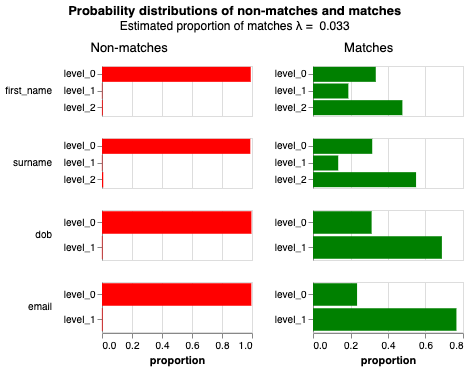

In [8]:
model = linker.model
model.probability_distribution_chart()

An alternative representation of the parameters displays them in terms of the effect different values in the comparison vectors have on the match probability:

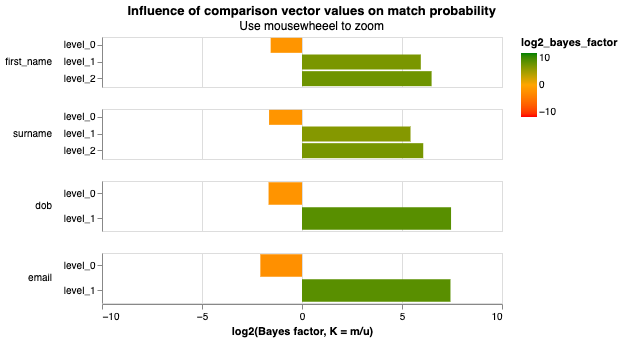

In [9]:
model.bayes_factor_chart()

In [10]:
# If charts aren't displaying correctly in your notebook, you can write them to a file (by default splink_charts.html)
model.all_charts_write_html_file("splink_charts.html", overwrite=True)

You can also generate a report which explains how the match probability was computed for an individual comparison row.  

Note that you need to convert the row to a dictionary for this to work

In [11]:
from splink.intuition import intuition_report
row_dict = df_e.toPandas().sample(1).to_dict(orient="records")[0]
print(intuition_report(row_dict, model))


Initial probability of match (prior) = λ = 0.03299
------
Comparison of first_name.  Values are:             
first_name_l:                                      Mia 
first_name_r:                                      None
Comparison has:                                    3 levels
Level for this comparison:                         gamma_first_name = -1
m probability = P(level|match):                    1
u probability = P(level|non-match):                1
Bayes factor = m/u:                                1
New probability of match (updated belief):         0.03299

------
Comparison of surname.  Values are:                
surname_l:                                         Campbell
surname_r:                                         Baxtr
Comparison has:                                    3 levels
Level for this comparison:                         gamma_surname = 0
m probability = P(level|match):                    0.3159
u probability = P(level|non-match):                0.9886
Baye

# Use graphframes to resolve links into groups

In [12]:
from splink.cluster import clusters_at_thresholds

thresholds = {"cluster_0_5": 0.5, "cluster_0_9": 0.9}
clusters_at_thresholds([df_1, df_2], df_e, thresholds, linker.model).toPandas()

,cluster_0_5,cluster_0_9,unique_id,first_name,surname,dob,city,email,group,source_dataset
0,0,0,101,None,Lee,2000-07-29,London,zlynch@miller.com,53,df_1
1,1,1,103,Emily,Brooks,1974-02-11,None,millssamuel@alvarez-henry.com,54,df_1
2,2,2,111,rFddie,Lane,2016-02-18,London,duanejames@reyes.net,59,df_1
3,3,3,12,Matilda,Hsrir,1983-04-30,London,patrcio47@davis.cam,6,df_1
4,4,4,122,Berry,Adam,1986-02-08,Loonn,None,64,df_1
...,...,...,...,...,...,...,...,...,...,...
995,33,33,78,Daniel,Ellis,2013-01-14,Stoke-on-Trent,wmcdaniel@nelson.net,22,df_2
996,60129542261,60129542261,8,Noah,None,2008-03-23,Blotn,None,1,df_2
997,60129542262,60129542262,86,None,Jones,1980-06-23,Lnoon,trobinson@garza.com,25,df_2
998,60129542263,60129542263,96,Harry,Taylr,2017-11-24,noLdo,coltonray@lee.com,26,df_2
